In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print (len(df))

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print (len(df))
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
4444706,352,BURITIS,894.0,-15.524262,-46.435536,A544,Buritis,MG,2012-12-18 18:00:00,2012-12-18,...,32.5,15.0,30.6,9.4,32.0,37.0,25.0,1.3,230.0,5.9
6584238,381,TERESÓPOLIS,991.0,-22.448922,-42.987146,A618,Teresópolis,RJ,2013-03-17 22:00:00,2013-03-17,...,19.8,19.3,19.5,18.8,97.0,97.0,96.0,0.5,91.0,2.2
6826431,384,VILA MILITAR,30.0,-22.861322,-43.411410,A621,Rio de Janeiro,RJ,2013-03-14 07:00:00,2013-03-14,...,25.7,23.2,25.2,22.8,87.0,88.0,86.0,0.4,106.0,2.3


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
#df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
#        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [8]:
df = df[df['wsid']==329]
print (len(df))

29112


In [9]:
df.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
816792,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 00:00:00,2006-12-01,...,20.7,20.5,20.4,20.2,99.0,99.0,98.0,1.0,121.0,2.6
816793,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 01:00:00,2006-12-01,...,20.9,20.6,20.7,20.5,98.0,99.0,98.0,1.2,146.0,2.0
816794,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 02:00:00,2006-12-01,...,20.9,20.6,20.5,20.3,98.0,98.0,98.0,0.5,309.0,2.0
816795,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 03:00:00,2006-12-01,...,20.7,20.5,20.6,20.3,98.0,98.0,98.0,NaN,356.0,0.9


# Pré-processamento

<h3>Dados ausentes</h3>

In [10]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [11]:
missing_values_count[missing_values_count > 0.1]

prcp    86.723688
gbrd    41.872767
wdsp     5.021984
gust     1.329349
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [15]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [16]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [17]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [18]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [19]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [20]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,29112.0,0.380702,2.269639,0.0,0.0,0.0,0.0,78.4
stp,29112.0,908.517257,89.239876,0.0,915.8,917.4,918.9,924.2
smax,29112.0,908.700110,89.580653,0.0,916.0,917.7,919.1,924.3
smin,29112.0,908.207399,89.532850,0.0,915.5,917.2,918.6,924.2
temp,29112.0,23.124210,3.927019,0.0,20.7,22.7,25.7,33.9
tmax,29112.0,17.124471,2.524743,0.0,16.1,17.5,18.7,22.6
tmin,29112.0,23.777490,4.147014,0.0,21.1,23.4,26.6,35.1
dewp,29112.0,17.726384,2.565495,0.0,16.7,18.0,19.2,23.6
dmax,29112.0,22.487236,3.703314,0.0,20.3,22.1,24.8,32.4
dmin,29112.0,16.565873,2.555016,0.0,15.5,17.0,18.2,21.6


In [21]:
df[cols] = df[cols].replace({0.0:np.nan})

In [22]:
print (len(df))
df  = df.dropna()
print (len(df))

29112
28832


<p>Verificando os mínimos e máximos por região.</p>

In [23]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,28832.0,0.384399,2.280322,0.0,0.0,0.0,0.0,78.4
stp,28832.0,917.276554,2.343445,906.5,915.8,917.4,918.9,924.2
smax,28832.0,917.524889,2.322062,906.7,916.1,917.7,919.1,924.3
smin,28832.0,917.027393,2.350573,906.4,915.6,917.2,918.6,924.2
temp,28832.0,23.347035,3.219508,15.3,20.7,22.8,25.7,33.9
tmax,28832.0,17.289442,1.892367,6.6,16.1,17.5,18.7,22.6
tmin,28832.0,24.008404,3.438123,16.4,21.2,23.4,26.6,35.1
dewp,28832.0,17.898533,1.887954,6.7,16.7,18.1,19.2,23.6
dmax,28832.0,22.705619,2.981447,15.0,20.3,22.1,24.9,32.4
dmin,28832.0,16.726752,1.974954,5.3,15.6,17.0,18.2,21.6


<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [24]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

tmin>tmax         wsid                  wsnm   elvt        lat        lon  inme  \
816792   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816793   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816794   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816795   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816796   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816797   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816798   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816799   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816800   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816801   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816802   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816803   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816804   329  BELO HOR. (PAMPULHA)  854.0

<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [25]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [26]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


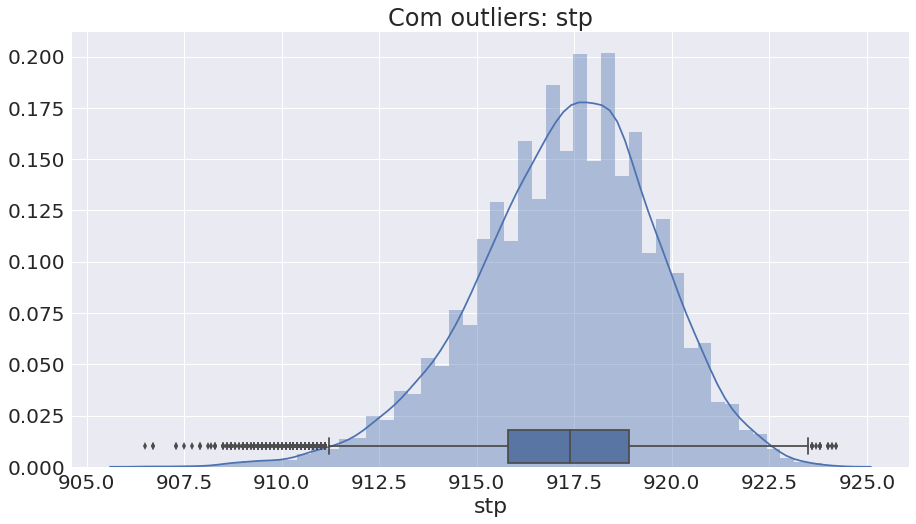

In [27]:
bp('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


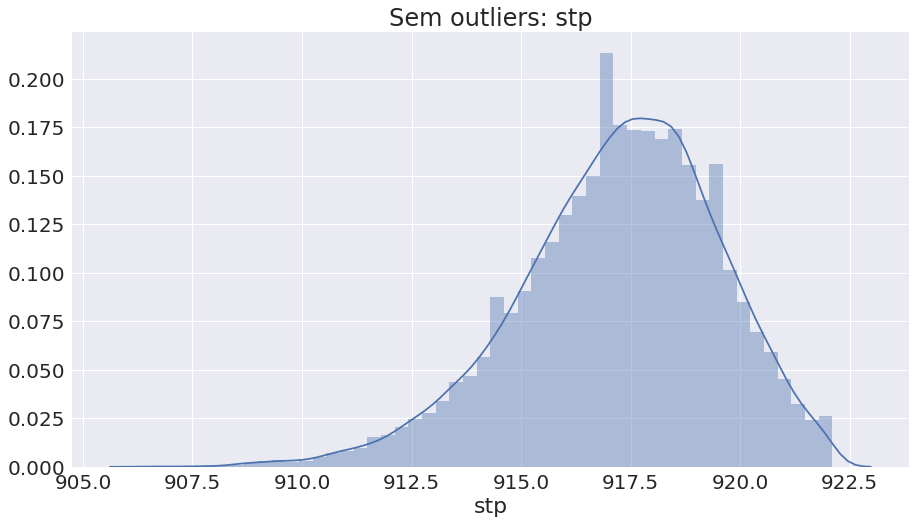

In [28]:
bp_sem('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


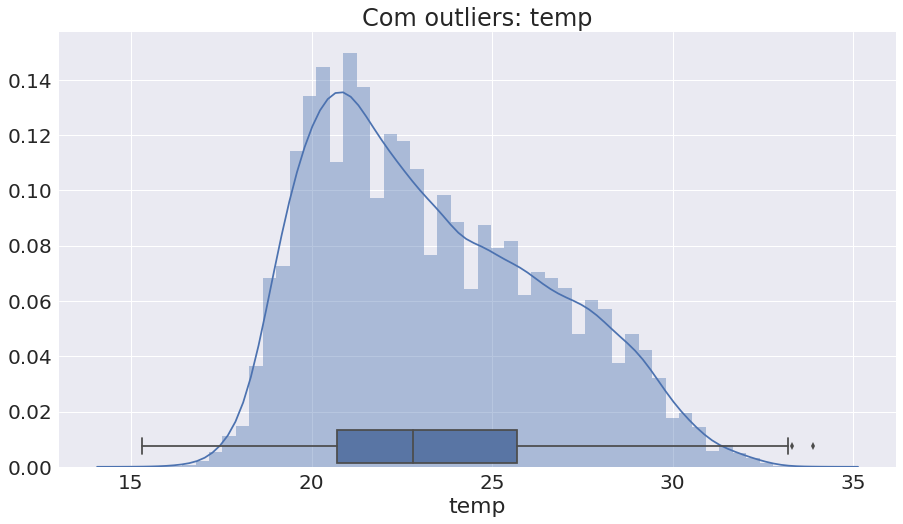

In [29]:
bp('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


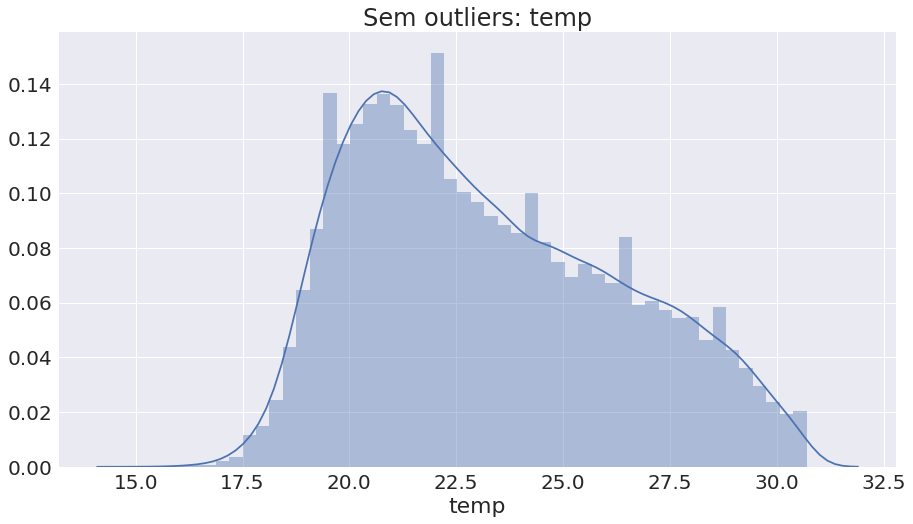

In [30]:
bp_sem('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


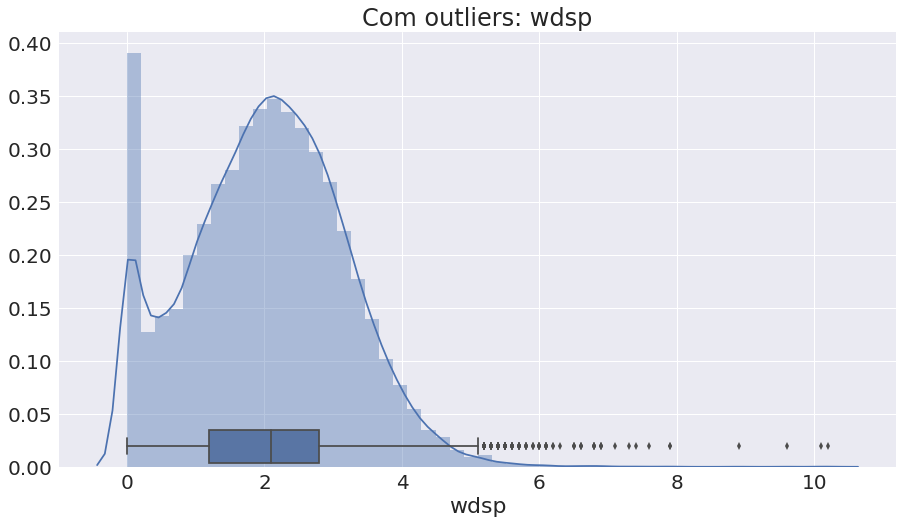

In [31]:
bp('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


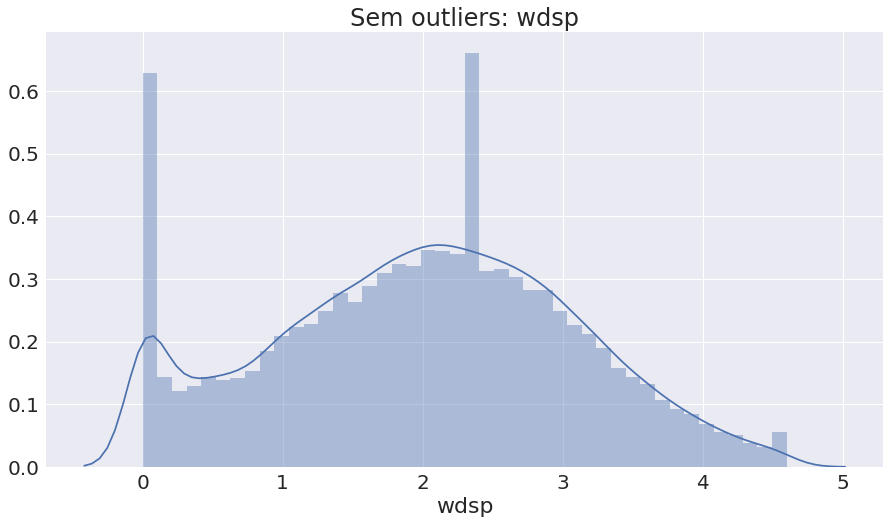

In [32]:
bp_sem('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


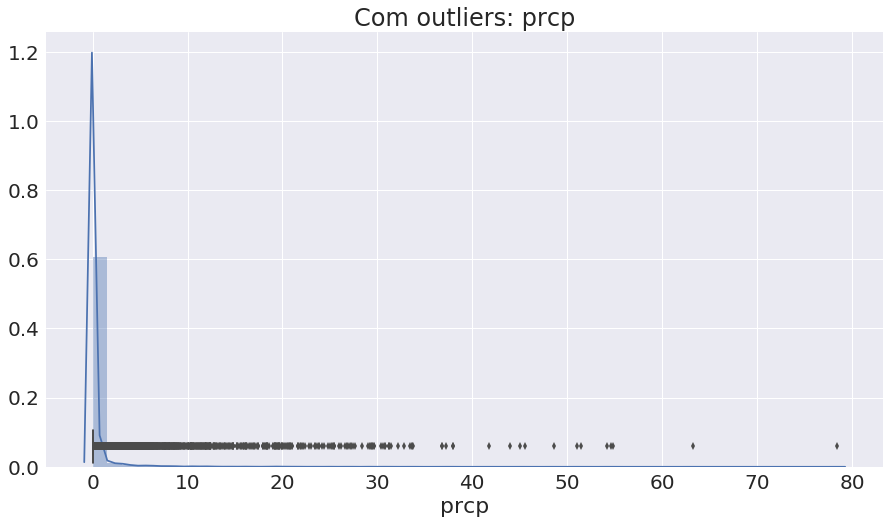

In [33]:
bp('prcp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


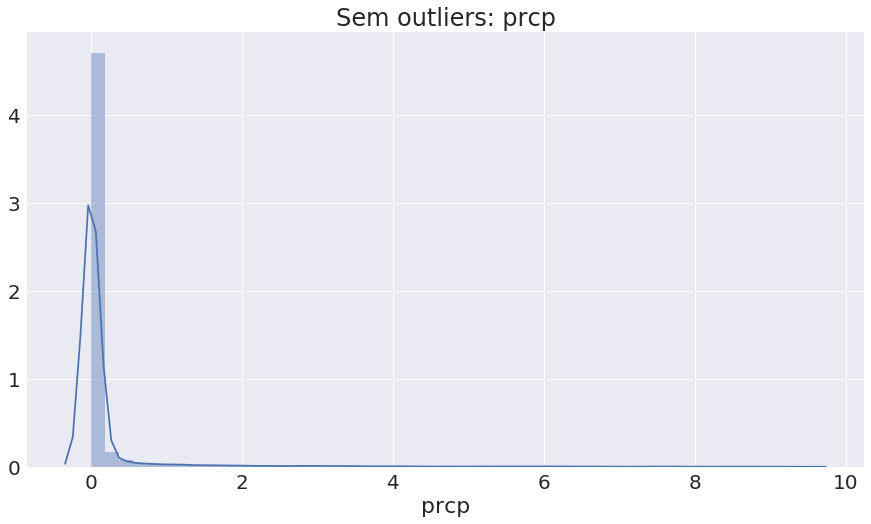

In [34]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [35]:
dfm = backup_df() 

In [36]:
len(dfm)

29112

In [37]:
dfm = dfm.drop('wdsp',1)
dfm = dfm.drop('wdct',1)
dfm = dfm.drop('gust',1)

<p>Conforme o Zarate orientou retirando o vento pois precisa ser modelado de forma diferente</p> 

In [38]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin
835671,329,854.0,-19.883945,-43.969397,2013-01-28 15:00:00,12.8,919.7,919.9,919.6,21.7,19.3,22.8,19.4,20.4,17.2,87.0,87.0,76.0
834372,329,854.0,-19.883945,-43.969397,2012-12-05 12:00:00,0.0,919.8,919.8,919.6,24.6,15.2,24.9,15.5,23.3,14.3,56.0,59.0,53.0
836882,329,854.0,-19.883945,-43.969397,2013-03-20 02:00:00,0.0,919.4,919.5,919.3,19.5,13.4,19.9,13.7,19.5,13.4,68.0,68.0,67.0
822256,329,854.0,-19.883945,-43.969397,2008-03-16 16:00:00,0.0,920.2,921.2,920.2,24.9,19.2,25.1,19.7,23.3,17.6,71.0,76.0,66.0
841119,329,854.0,-19.883945,-43.969397,2015-01-13 15:00:00,0.0,919.3,919.8,919.3,30.0,13.1,31.6,15.2,29.6,12.8,36.0,40.0,34.0


In [39]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print (ws)

[329]


In [40]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [41]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,24,NON_DER)

In [42]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [43]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [44]:
xxx = dfr.copy()

In [45]:
# Inicializando
xxx['prcp_acum_24'] = 99.99
xxx['prcp_plus_12'] = 99.99

In [46]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_24')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_12')
    
    j=11
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_24'].index[i],'prcp_acum_24'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+24,pos_prcp].sum()
        if i+12 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+12,pos_prcp].sum()
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12']  = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+j,pos_prcp].sum()
            j-=1

In [47]:
dfr = xxx 

In [48]:
dfr.head(12)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
816792,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816793,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816794,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2,15.4
816795,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,15.0
816796,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,13.6
816797,329,854.0,-19.883945,-43.969397,2006-12-01 05:00:00,0.6,913.8,914.4,913.8,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,1.2
816798,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816799,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816800,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816801,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,0.6


In [49]:
dfr.columns

Index(['wsid', 'elvt', 'lat', 'lon', 'mdct', 'prcp', 'stp', 'smax', 'smin',
       'temp',
       ...
       'dmax_17', 'dmax_18', 'dmax_19', 'dmax_20', 'dmax_21', 'dmax_22',
       'dmax_23', 'dmax_24', 'prcp_acum_24', 'prcp_plus_12'],
      dtype='object', length=356)

In [50]:
dfm = dfr

In [51]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'mdct_1',
 'mdct_2',
 'mdct

In [52]:
len(dfm)

29112

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [53]:
cols = list(df.columns)
for v in ['wdsp','wdct','gust']:
    cols.remove(v)

In [54]:
COLS_BE_NULL = ['prcp'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin']

In [55]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [56]:
print (len(dfm))
dfm  = dfm.dropna()
print (len(dfm))

29112
27721


In [57]:
dfm = dfm.reset_index(drop=True)

In [58]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
0,329,854.0,-19.883945,-43.969397,2006-12-02 00:00:00,0.0,918.2,918.2,917.5,18.8,...,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0,2.0
1,329,854.0,-19.883945,-43.969397,2006-12-02 01:00:00,0.4,918.7,918.7,918.2,18.6,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0,2.0
2,329,854.0,-19.883945,-43.969397,2006-12-02 02:00:00,1.0,918.7,918.8,918.7,18.4,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6,1.6
3,329,854.0,-19.883945,-43.969397,2006-12-02 03:00:00,0.2,918.1,918.7,918.1,18.6,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,0.6,0.6
4,329,854.0,-19.883945,-43.969397,2006-12-02 04:00:00,0.0,917.3,918.1,917.3,18.7,...,21.2,20.6,19.9,19.9,20.2,20.1,20.2,20.4,0.4,0.4


In [59]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [60]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'mdct_1',
 'mdct_2',
 'mdct_3',
 'mdct_4',
 '

In [61]:
REMOVE = ['mdct']
for i in range(1,25):
    REMOVE.append('mdct_'+str(i))
print (REMOVE)
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

['mdct', 'mdct_1', 'mdct_2', 'mdct_3', 'mdct_4', 'mdct_5', 'mdct_6', 'mdct_7', 'mdct_8', 'mdct_9', 'mdct_10', 'mdct_11', 'mdct_12', 'mdct_13', 'mdct_14', 'mdct_15', 'mdct_16', 'mdct_17', 'mdct_18', 'mdct_19', 'mdct_20', 'mdct_21', 'mdct_22', 'mdct_23', 'mdct_24']


In [62]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'temp_1',
 'temp_2',
 'temp_3',
 'temp_4',
 'temp_5',
 'temp_6',
 'temp_7',
 'temp_8',
 'temp_9',
 'temp_10',
 'temp_11',
 'temp_12',
 'temp_13',
 'temp_14',
 'temp_15',
 'temp_16',
 'temp_17',
 'temp_18',
 'temp_19',
 'temp_20',
 'temp_21',
 'temp_22',
 'temp_23',
 'temp_24',
 'stp_1',
 'stp_2',
 'stp_3',
 'stp_4',
 'stp_5',
 'stp_6',
 'stp_7',
 'stp_8',
 'stp_9',
 'stp_10',
 'stp_11',
 'stp_12',
 'stp_13',
 'stp_14',
 'stp_15',
 'stp_16',
 'stp_17',
 'stp_18',
 'stp_19',
 'stp_20',
 'stp_21',
 'stp_22',
 'stp_23',
 'stp_24',
 'dewp_1',
 'dewp_2',
 'dewp_3',
 'dewp_4',
 '

In [63]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [64]:
#dfm = dfm.drop('wsid',1)
#dfm

In [65]:
#dfm.loc[28807,'prcp_plus_1'] = 0.0
#x = dfm[dfm['prcp_plus_1']==99.99]
#x

In [66]:
#dfm.to_csv('../data/derivaded_3.csv')

In [5]:
dfm = pd.read_csv('../data/derivaded_3.csv',index_col=0)
print (len(dfm))
dfm.head(24)

27721


,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,20.2,20.1,20.2,20.4,20.6,20.5,20.7,20.4,2.0,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,19.9,20.2,20.1,20.2,20.4,20.6,20.5,20.7,2.0,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,19.9,19.9,20.2,20.1,20.2,20.4,20.6,20.5,1.6,1.6
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,20.6,19.9,19.9,20.2,20.1,20.2,20.4,20.6,0.6,0.6
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,21.2,20.6,19.9,19.9,20.2,20.1,20.2,20.4,0.4,0.4
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,21.9,21.2,20.6,19.9,19.9,20.2,20.1,20.2,0.4,0.4
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,22.2,21.9,21.2,20.6,19.9,19.9,20.2,20.1,0.4,0.4
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,21.8,22.2,21.9,21.2,20.6,19.9,19.9,20.2,0.4,0.4
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,22.1,21.8,22.2,21.9,21.2,20.6,19.9,19.9,0.4,0.4
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,22.3,22.1,21.8,22.2,21.9,21.2,20.6,19.9,0.0,0.0


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [66]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [67]:
target = 'prcp_acum_24'

In [68]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [69]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=12) 
print (len(X_train))
print (len(X_tmp))

22176
5545


<p>Separando o conjunto de testes</p>

In [70]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [71]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   22176, Training features   327
Validation instances 2773, Validation features 327
Testing instances    2772, Testing features    327


In [72]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = X_train.shape[1] 
#activation_fn = tf.sigmoid
batch_size = 1000
up = int(len(X_train)/batch_size)

In [73]:
Z = X.copy()
Z.pop(target)
Z.pop('prcp_plus_12')
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [74]:
feature_cols

[_NumericColumn(key='prcp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='stp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='smin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='temp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='tmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dewp', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmax', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='dmin', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericCo

In [75]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols
                                      ,hidden_units=[st_units,sd_units]
                                      #,activation_fn=activation_fn
                                      ,model_dir='/tmp/tf_model_10')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_service': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_tf_random_seed': None, '_task_id': 0, '_save_checkpoints_secs': 600, '_global_id_in_cluster': 0, '_is_chief': True, '_master': '', '_log_step_count_steps': 100, '_session_config': None, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '/tmp/tf_model_10', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f5b2209bda0>, '_num_worker_replicas': 1, '_evaluation_master': '', '_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_task_type': 'worker'}


In [76]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=batch_size):      
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [77]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [78]:
X_train

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,dmax_17,dmax_18,dmax_19,dmax_20,dmax_21,dmax_22,dmax_23,dmax_24,prcp_acum_24,prcp_plus_12
17121,0.0,917.6,918.3,917.6,21.0,16.1,21.7,16.6,21.0,16.1,...,22.4,22.3,22.5,23.5,23.0,24.1,24.4,24.7,2.6,0.0
6881,0.0,916.3,916.3,916.1,20.3,17.7,20.5,17.9,20.0,17.7,...,26.4,25.6,24.9,23.0,21.4,19.8,19.1,18.4,11.4,0.2
21250,0.4,916.3,916.3,915.5,20.2,18.5,20.4,18.9,19.7,18.4,...,18.6,18.8,19.0,19.5,19.4,20.2,22.5,23.6,2.0,0.8
26825,0.0,916.9,917.1,916.9,23.4,15.4,23.7,15.9,23.3,15.4,...,26.2,25.3,23.1,21.9,21.5,22.4,22.8,22.7,0.0,0.0
26511,0.0,920.1,920.2,920.1,23.7,15.7,23.8,16.0,23.3,15.7,...,22.7,21.9,21.6,22.3,22.8,23.1,23.4,23.4,0.0,0.0
6662,0.0,916.2,916.4,916.1,20.3,18.1,20.3,18.2,20.1,18.1,...,19.6,18.9,18.5,18.3,18.2,18.3,18.7,18.6,0.0,0.0
20087,0.0,921.8,921.9,921.5,23.8,16.7,24.0,17.2,22.3,15.9,...,27.6,27.2,27.2,26.0,24.6,24.1,23.4,22.9,0.0,0.0
21743,5.2,919.8,919.8,919.1,21.1,19.9,22.0,20.7,21.0,19.8,...,29.7,30.3,27.9,28.2,27.0,25.5,24.7,22.8,5.8,5.8
20528,0.0,919.1,919.1,919.0,28.3,13.3,29.0,14.0,27.6,11.4,...,22.2,22.4,22.7,23.3,24.0,25.0,26.3,26.5,0.0,0.0
2996,0.0,916.2,916.5,916.2,20.8,18.6,21.1,18.7,20.6,18.3,...,23.5,22.6,21.8,19.9,19.0,19.0,19.0,19.1,3.0,0.0


In [127]:
def balancear(_X, _y):
    
    def f(x):
        if x['prcp_acum_24'] <= 0.0: 
            return 0
        elif x['prcp_acum_24'] < 50:       
            return 1
        else:
            return 2        
        
    #Balancear considerando apenas com chuva e sem chuva.    
    _X['rain'] = _X.apply(f,axis=1) 
    
    _X_resampled, _y_resampled, idx_resampled = under.fit_sample(_X, _X['rain'])
    
    _X = pd.DataFrame(_X_resampled, columns = _X.columns)
    _y = pd.DataFrame(_y_resampled, columns =['rain'])
    
    _y = _X['prcp_acum_24']
    
    _X = _X.drop('rain',1)
    _X = _X.drop('prcp_plus_12',1)
    #_X = _X.drop('prcp_acum_24',1)
    
    return _X,_y

In [128]:
#X_val = X_val.drop('prcp_plus_12',1)
#X_val = X_val.drop('prcp_acum_24',1)

In [129]:
def f(x):
    if x['prcp_acum_24'] <= 0.0: 
        return 0
    elif x['prcp_acum_24'] < 50:       
        return 1
    else:
        return 2   

In [137]:
#A, b = balancear(X_train.copy(), y_train.copy())

In [138]:
#A['rain'] = A.apply(f,axis=1) 

In [139]:
#g = A.groupby('rain')
#g.count()

In [140]:
#b.groupby(pd.cut(b.values, [-50,   0,  49.99, 200])).count()

In [141]:
#len(A)

3273

In [142]:
evaluations = []  
STEPS = 500  

for i in range(1, 200):    
    
    A, b = balancear(X_train.copy(), y_train.copy())
    
    print ('treinando agora...')
    
    regressor.train(input_fn=wx_input_fn(A ,b), steps=STEPS)
    
    evaluations.append(
        regressor.evaluate(input_fn=wx_input_fn(X_val
                                                ,y_val
                                                ,num_epochs=1
                                                ,shuffle=False)))

treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 228672140.0, step = 1
INFO:tensorflow:global_step/sec: 3.00905
INFO:tensorflow:loss = 1316767.8, step = 101 (33.232 sec)
INFO:tensorflow:global_step/sec: 3.05095
INFO:tensorflow:loss = 1859424.6, step = 201 (32.776 sec)
INFO:tensorflow:global_step/sec: 3.03999
INFO:tensorflow:loss = 1357070.4, step = 301 (32.895 sec)
INFO:tensorflow:global_step/sec: 3.03419
INFO:tensorflow:loss = 2062495.4, step = 401 (32.958 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 539820.75.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evalu

INFO:tensorflow:Loss for final step: 1052536.8.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-03:19:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-03:19:19
INFO:tensorflow:Saving dict for global step 3000: average_loss = 825.4937, global_step = 3000, loss = 763031.3
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1075869.4, step = 3001


INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 331902.22, step = 5501
INFO:tensorflow:global_step/sec: 3.01205
INFO:tensorflow:loss = 1491609.2, step = 5601 (33.202 sec)
INFO:tensorflow:global_step/sec: 3.06868
INFO:tensorflow:loss = 719798.56, step = 5701 (32.587 sec)
INFO:tensorflow:global_step/sec: 3.12067
INFO:tensorflow:loss = 937343.9, step = 5801 (32.044 sec)
INFO:tensorflow:global_step/sec: 3.05321
INFO:tensorflow:loss = 757926.6, step = 5901 (32.752 sec)
INFO:tensorflow:Saving checkpoints for 6000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1390422.9.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-03:36:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-6000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done runn

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-03:51:34
INFO:tensorflow:Saving dict for global step 8500: average_loss = 957.8864, global_step = 8500, loss = 885406.3
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 916958.6, step = 8501
INFO:tensorflow:global_step/sec: 3.04109
INFO:tensorflow:loss = 1100109.0, step = 8601 (32.884 sec)
INFO:tensorflow:global_step/sec: 3.0589
INFO:tensorflow:loss = 895501.5, step = 8

INFO:tensorflow:global_step/sec: 2.98124
INFO:tensorflow:loss = 734348.0, step = 11101 (33.544 sec)
INFO:tensorflow:global_step/sec: 3.1086
INFO:tensorflow:loss = 1346938.4, step = 11201 (32.169 sec)
INFO:tensorflow:global_step/sec: 3.19473
INFO:tensorflow:loss = 720829.9, step = 11301 (31.301 sec)
INFO:tensorflow:global_step/sec: 3.1676
INFO:tensorflow:loss = 862541.1, step = 11401 (31.570 sec)
INFO:tensorflow:Saving checkpoints for 11500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 763046.3.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-04:09:10
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-11500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-04:09:12
INFO:tensorflow:Saving dict for global step 11500: average_loss = 466.16324, global_step

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-04:23:42
INFO:tensorflow:Saving dict for global step 14000: average_loss = 444.16635, global_step = 14000, loss = 410557.75
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 752482.5, step = 14001
INFO:tensorflow:global_step/sec: 3.12791
INFO:tensorflow:loss = 1127601.0, step = 14101 (31.972 sec)
INFO:tensorflow:global_step/sec: 3.0341
INFO:tensorflow:loss = 801696.0, step = 14201 (32.959 sec)
INFO:tensorflow:global_step/sec: 3.0422
INFO:tensorflow:loss = 1296393.6, step = 14301

INFO:tensorflow:global_step/sec: 3.04228
INFO:tensorflow:loss = 1452237.5, step = 16701 (32.870 sec)
INFO:tensorflow:global_step/sec: 2.94468
INFO:tensorflow:loss = 686000.0, step = 16801 (33.960 sec)
INFO:tensorflow:global_step/sec: 3.0299
INFO:tensorflow:loss = 978650.25, step = 16901 (33.004 sec)
INFO:tensorflow:Saving checkpoints for 17000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 823305.44.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-04:41:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-17000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-04:41:15
INFO:tensorflow:Saving dict for global step 17000: average_loss = 464.40427, global_step = 17000, loss = 429264.34
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:D

INFO:tensorflow:Saving dict for global step 19500: average_loss = 511.4963, global_step = 19500, loss = 472793.1
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-19500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 435977.5, step = 19501
INFO:tensorflow:global_step/sec: 2.99847
INFO:tensorflow:loss = 1324875.1, step = 19601 (33.352 sec)
INFO:tensorflow:global_step/sec: 3.06195
INFO:tensorflow:loss = 696720.8, step = 19701 (32.659 sec)
INFO:tensorflow:global_step/sec: 3.10363
INFO:tensorflow:loss = 880669.9, step = 19801 (32.220 sec)
INFO:tensorflow:global_step/sec: 3.01804
INFO:tensorflow:loss = 717517.9, step = 19901 (33.134 sec)
INFO:tensorflow:Saving checkp

INFO:tensorflow:global_step/sec: 3.15304
INFO:tensorflow:loss = 752262.1, step = 22301 (31.715 sec)
INFO:tensorflow:global_step/sec: 3.13146
INFO:tensorflow:loss = 1294833.4, step = 22401 (31.935 sec)
INFO:tensorflow:Saving checkpoints for 22500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 777513.4.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-05:13:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-22500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-05:13:28
INFO:tensorflow:Saving dict for global step 22500: average_loss = 628.613, global_step = 22500, loss = 581047.94
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-25000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 25001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1526996.0, step = 25001
INFO:tensorflow:global_step/sec: 3.06957
INFO:tensorflow:loss = 660221.44, step = 25101 (32.579 sec)
INFO:tensorflow:global_step/sec: 3.13091
INFO:tensorflow:loss = 1277088.9, step = 25201 (31.940 sec)
INFO:tensorflow:global_step/sec: 3.15112
INFO:tensorflow:loss = 671510.94, step = 25301 (31.734 sec)
INFO:tensorflow:global_step/sec: 3.15714
INFO:tensorflow:loss = 812141.7, step = 25401 (31.675 sec)
INFO:tensorflow:Saving checkpoints for 25500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 699481.25.
INFO:tensorf

INFO:tensorflow:global_step/sec: 3.00646
INFO:tensorflow:loss = 625681.9, step = 27901 (33.262 sec)
INFO:tensorflow:Saving checkpoints for 28000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1010728.1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-05:45:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-28000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-05:45:20
INFO:tensorflow:Saving dict for global step 28000: average_loss = 516.99805, global_step = 28000, loss = 477878.53
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-28000
INFO:tensorflow:Runnin

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-30500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 30501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1101157.8, step = 30501
INFO:tensorflow:global_step/sec: 3.02243
INFO:tensorflow:loss = 707890.0, step = 30601 (33.087 sec)
INFO:tensorflow:global_step/sec: 3.07885
INFO:tensorflow:loss = 716221.75, step = 30701 (32.480 sec)
INFO:tensorflow:global_step/sec: 3.0288
INFO:tensorflow:loss = 747954.6, step = 30801 (33.017 sec)
INFO:tensorflow:global_step/sec: 3.04173
INFO:tensorflow:loss = 663751.25, step = 30901 (32.876 sec)
INFO:tensorflow:Saving checkpoints for 31000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 623641.06.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:Saving checkpoints for 33500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 684952.1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-06:17:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-33500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-06:17:35
INFO:tensorflow:Saving dict for global step 33500: average_loss = 412.42508, global_step = 33500, loss = 381218.25
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-33500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-36000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 36001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1352915.6, step = 36001
INFO:tensorflow:global_step/sec: 3.0687
INFO:tensorflow:loss = 653978.1, step = 36101 (32.588 sec)
INFO:tensorflow:global_step/sec: 3.10614
INFO:tensorflow:loss = 761584.4, step = 36201 (32.195 sec)
INFO:tensorflow:global_step/sec: 3.14468
INFO:tensorflow:loss = 809194.9, step = 36301 (31.800 sec)
INFO:tensorflow:global_step/sec: 3.16545
INFO:tensorflow:loss = 679974.9, step = 36401 (31.591 sec)
INFO:tensorflow:Saving checkpoints for 36500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 667117.2.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-06:35:09
INFO:tensorflow:Graph

INFO:tensorflow:Loss for final step: 988243.94.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-06:49:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-39000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-06:49:50
INFO:tensorflow:Saving dict for global step 39000: average_loss = 552.2298, global_step = 39000, loss = 510444.4
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-39000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 39001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1033898.2, step = 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 41501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 708732.94, step = 41501
INFO:tensorflow:global_step/sec: 3.00121
INFO:tensorflow:loss = 908619.3, step = 41601 (33.322 sec)
INFO:tensorflow:global_step/sec: 3.17954
INFO:tensorflow:loss = 675792.75, step = 41701 (31.451 sec)
INFO:tensorflow:global_step/sec: 3.04991
INFO:tensorflow:loss = 1096089.2, step = 41801 (32.788 sec)
INFO:tensorflow:global_step/sec: 3.03792
INFO:tensorflow:loss = 660470.8, step = 41901 (32.917 sec)
INFO:tensorflow:Saving checkpoints for 42000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 651898.1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-07:07:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-42000
INFO:tensorflow:Ru

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-07:22:00
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-44500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-07:22:03
INFO:tensorflow:Saving dict for global step 44500: average_loss = 389.7892, global_step = 44500, loss = 360295.16
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-44500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 44501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1511218.4, step = 44501
INFO:tensorflow:global_step/sec: 3.15291
INFO:tensorflow:loss = 740911.0, s

INFO:tensorflow:Saving checkpoints for 47001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 644879.2, step = 47001
INFO:tensorflow:global_step/sec: 3.11054
INFO:tensorflow:loss = 656561.8, step = 47101 (32.150 sec)
INFO:tensorflow:global_step/sec: 3.09521
INFO:tensorflow:loss = 913356.06, step = 47201 (32.308 sec)
INFO:tensorflow:global_step/sec: 3.02703
INFO:tensorflow:loss = 699606.1, step = 47301 (33.036 sec)
INFO:tensorflow:global_step/sec: 3.14503
INFO:tensorflow:loss = 1074679.5, step = 47401 (31.796 sec)
INFO:tensorflow:Saving checkpoints for 47500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 874121.9.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-07:39:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-47500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Fin

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-07:53:57
INFO:tensorflow:Saving dict for global step 50000: average_loss = 510.48026, global_step = 50000, loss = 471853.9
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 50001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 834999.9, step = 50001
INFO:tensorflow:global_step/sec: 3.03891
INFO:tensorflow:loss = 738284.6, step = 50101 (32.908 sec)
INFO:tensorflow:global_step/sec: 3.10623
INFO:tensorflow:loss = 1150248.5,

INFO:tensorflow:loss = 1409918.1, step = 52501
INFO:tensorflow:global_step/sec: 3.02062
INFO:tensorflow:loss = 653825.5, step = 52601 (33.107 sec)
INFO:tensorflow:global_step/sec: 3.01194
INFO:tensorflow:loss = 1225651.1, step = 52701 (33.203 sec)
INFO:tensorflow:global_step/sec: 3.06617
INFO:tensorflow:loss = 673411.25, step = 52801 (32.613 sec)
INFO:tensorflow:global_step/sec: 3.03764
INFO:tensorflow:loss = 767665.5, step = 52901 (32.920 sec)
INFO:tensorflow:Saving checkpoints for 53000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 658042.6.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-08:11:31
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-53000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-08:11:34
INFO:tensorflow:Saving dict for global

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-08:25:59
INFO:tensorflow:Saving dict for global step 55500: average_loss = 408.64163, global_step = 55500, loss = 377721.1
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-55500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 55501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 255367.47, step = 55501
INFO:tensorflow:global_step/sec: 3.01826
INFO:tensorflow:loss = 1288431.8, step = 55601 (33.133 sec)
INFO:tensorflow:global_step/sec: 3.05173
INFO:tensorflow:loss = 672311.1, step = 55701 (32.769 sec)
INFO:tensorflow:global_step/sec: 3.04692
INFO:tensorflow:loss = 1120085.5, step = 558

INFO:tensorflow:loss = 865454.6, step = 58101 (33.062 sec)
INFO:tensorflow:global_step/sec: 3.04503
INFO:tensorflow:loss = 733120.1, step = 58201 (32.840 sec)
INFO:tensorflow:global_step/sec: 3.00624
INFO:tensorflow:loss = 722435.1, step = 58301 (33.264 sec)
INFO:tensorflow:global_step/sec: 3.01425
INFO:tensorflow:loss = 995105.7, step = 58401 (33.176 sec)
INFO:tensorflow:Saving checkpoints for 58500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1282526.2.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-08:43:21
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-58500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-08:43:23
INFO:tensorflow:Saving dict for global step 58500: average_loss = 804.3388, global_step = 58500, loss = 743477.2
treinando agor

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-08:58:08
INFO:tensorflow:Saving dict for global step 61000: average_loss = 758.4488, global_step = 61000, loss = 701059.5
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-61000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 61001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 936407.6, step = 61001
INFO:tensorflow:global_step/sec: 3.03141
INFO:tensorflow:loss = 668472.9, step = 61101 (32.989 sec)
INFO:tensorflow:global_step/sec: 3.05602
INFO:tensorflow:loss = 924024.9, step = 61201 (32.722 sec)
INFO:tensorflow:global_step/sec: 3.06443
INFO:tensorflow:loss = 680257.06, step = 61301 (32.633 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:global_step/sec: 3.04779
INFO:tensorflow:loss = 707615.0, step = 63701 (32.811 sec)
INFO:tensorflow:global_step/sec: 3.03343
INFO:tensorflow:loss = 720001.9, step = 63801 (32.966 sec)
INFO:tensorflow:global_step/sec: 3.02712
INFO:tensorflow:loss = 906363.2, step = 63901 (33.034 sec)
INFO:tensorflow:Saving checkpoints for 64000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1301072.9.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-09:15:44
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-64000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-09:15:46
INFO:tensorflow:Saving dict for global step 64000: average_loss = 758.2069, global_step = 64000, loss = 700835.94
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Don

INFO:tensorflow:Saving dict for global step 66500: average_loss = 409.7295, global_step = 66500, loss = 378726.62
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-66500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 66501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1483760.8, step = 66501
INFO:tensorflow:global_step/sec: 3.04149
INFO:tensorflow:loss = 678339.0, step = 66601 (32.880 sec)
INFO:tensorflow:global_step/sec: 3.10038
INFO:tensorflow:loss = 767625.44, step = 66701 (32.254 sec)
INFO:tensorflow:global_step/sec: 3.17701
INFO:tensorflow:loss = 761219.6, step = 66801 (31.476 sec)
INFO:tensorflow:global_step/sec: 3.09151
INFO:tensorflow:loss = 691948.4, step = 66901 (32.347 sec)
INFO:tensorflow:Saving chec

INFO:tensorflow:global_step/sec: 3.15263
INFO:tensorflow:loss = 659456.0, step = 69301 (31.719 sec)
INFO:tensorflow:global_step/sec: 3.17009
INFO:tensorflow:loss = 1086186.8, step = 69401 (31.545 sec)
INFO:tensorflow:Saving checkpoints for 69500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 961992.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-09:47:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-69500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-09:47:35
INFO:tensorflow:Saving dict for global step 69500: average_loss = 741.8832, global_step = 69500, loss = 685747.3
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-72000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 72001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 415116.06, step = 72001
INFO:tensorflow:global_step/sec: 3.11118
INFO:tensorflow:loss = 1050332.6, step = 72101 (32.143 sec)
INFO:tensorflow:global_step/sec: 3.02479
INFO:tensorflow:loss = 636155.5, step = 72201 (33.061 sec)
INFO:tensorflow:global_step/sec: 3.04905
INFO:tensorflow:loss = 759154.25, step = 72301 (32.797 sec)
INFO:tensorflow:global_step/sec: 3.04271
INFO:tensorflow:loss = 758078.6, step = 72401 (32.865 sec)
INFO:tensorflow:Saving checkpoints for 72500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1288350.0.
INFO:tensorfl

INFO:tensorflow:global_step/sec: 3.02307
INFO:tensorflow:loss = 617493.0, step = 74901 (33.079 sec)
INFO:tensorflow:Saving checkpoints for 75000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 769607.9.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-10:19:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-75000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-10:19:53
INFO:tensorflow:Saving dict for global step 75000: average_loss = 431.65353, global_step = 75000, loss = 398991.75
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-75000
INFO:tensorflow:Running

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-77500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 77501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 426382.3, step = 77501
INFO:tensorflow:global_step/sec: 3.02287
INFO:tensorflow:loss = 1293090.6, step = 77601 (33.087 sec)
INFO:tensorflow:global_step/sec: 3.02838
INFO:tensorflow:loss = 636494.4, step = 77701 (33.017 sec)
INFO:tensorflow:global_step/sec: 3.09073
INFO:tensorflow:loss = 956201.0, step = 77801 (32.355 sec)
INFO:tensorflow:global_step/sec: 3.03766
INFO:tensorflow:loss = 669835.25, step = 77901 (32.920 sec)
INFO:tensorflow:Saving checkpoints for 78000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 1046593.8.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling mode

INFO:tensorflow:Saving checkpoints for 80500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 626448.2.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-10:51:55
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-80500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-10:51:57
INFO:tensorflow:Saving dict for global step 80500: average_loss = 497.14633, global_step = 80500, loss = 459528.9
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-80500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 80

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-83000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 83001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 525941.8, step = 83001
INFO:tensorflow:global_step/sec: 3.02188
INFO:tensorflow:loss = 1032823.06, step = 83101 (33.093 sec)
INFO:tensorflow:global_step/sec: 2.93718
INFO:tensorflow:loss = 643821.25, step = 83201 (34.047 sec)
INFO:tensorflow:global_step/sec: 3.07552
INFO:tensorflow:loss = 1192704.2, step = 83301 (32.515 sec)
INFO:tensorflow:global_step/sec: 3.0828
INFO:tensorflow:loss = 637871.7, step = 83401 (32.438 sec)
INFO:tensorflow:Saving checkpoints for 83500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 801794.75.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-11:09:36
INFO:tensorflow:G

INFO:tensorflow:Loss for final step: 640539.6.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-11:24:19
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-86000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-11:24:22
INFO:tensorflow:Saving dict for global step 86000: average_loss = 415.83286, global_step = 86000, loss = 384368.16
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-86000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 86001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 1420193.9, step =

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 88501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 362262.8, step = 88501
INFO:tensorflow:global_step/sec: 3.07702
INFO:tensorflow:loss = 1007350.6, step = 88601 (32.500 sec)
INFO:tensorflow:global_step/sec: 3.12185
INFO:tensorflow:loss = 631793.4, step = 88701 (32.033 sec)
INFO:tensorflow:global_step/sec: 3.15369
INFO:tensorflow:loss = 1244665.5, step = 88801 (31.708 sec)
INFO:tensorflow:global_step/sec: 3.18491
INFO:tensorflow:loss = 658947.5, step = 88901 (31.399 sec)
INFO:tensorflow:Saving checkpoints for 89000 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 954373.0.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-11:41:43
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-89000
INFO:tensorflow:Run

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-11:56:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-91500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-11:56:18
INFO:tensorflow:Saving dict for global step 91500: average_loss = 407.89136, global_step = 91500, loss = 377027.6
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-91500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 91501 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 404983.3, step = 91501
INFO:tensorflow:global_step/sec: 3.0562
INFO:tensorflow:loss = 1051715.0, st

INFO:tensorflow:Saving checkpoints for 94001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 912481.1, step = 94001
INFO:tensorflow:global_step/sec: 3.0841
INFO:tensorflow:loss = 695956.3, step = 94101 (32.426 sec)
INFO:tensorflow:global_step/sec: 3.11353
INFO:tensorflow:loss = 767091.0, step = 94201 (32.118 sec)
INFO:tensorflow:global_step/sec: 3.11737
INFO:tensorflow:loss = 764897.5, step = 94301 (32.078 sec)
INFO:tensorflow:global_step/sec: 3.03244
INFO:tensorflow:loss = 615821.1, step = 94401 (32.977 sec)
INFO:tensorflow:Saving checkpoints for 94500 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 635568.1.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-17-12:13:49
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-94500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finish

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-97000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-17-12:28:29
INFO:tensorflow:Saving dict for global step 97000: average_loss = 484.815, global_step = 97000, loss = 448130.66
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-97000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 97001 into /tmp/tf_model_10/model.ckpt.
INFO:tensorflow:loss = 803649.25, step = 97001
INFO:tensorflow:global_step/sec: 3.1415
INFO:tensorflow:loss = 716263.9, step = 97101 (31.833 sec)
INFO:tensorflow:global_step/sec: 3.18689
INFO:tensorflow:loss = 1094041.1, 

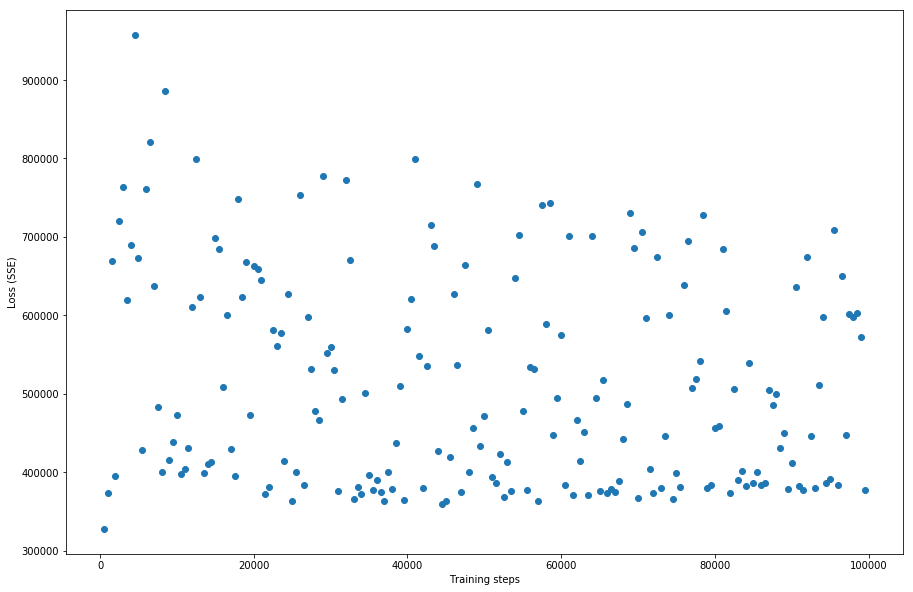

In [143]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [144]:
X_test = X_test.drop('prcp_plus_12',1)
X_test = X_test.drop('prcp_acum_24',1)

In [145]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,  
                                              num_epochs=1,
                                              shuffle=False))

predictions = np.array([p['predictions'][0] for p in pred])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_model_10/model.ckpt-99500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [146]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: -0.10
The Mean Absolute Error: 14.50 
The Median Absolute Error: 9.51 


In [147]:
predictions

array([-8.248486 , -0.3538018, -2.190014 , ..., -7.088314 , -8.741619 ,
       20.26067  ], dtype=float32)

In [148]:
predictions.size

2772

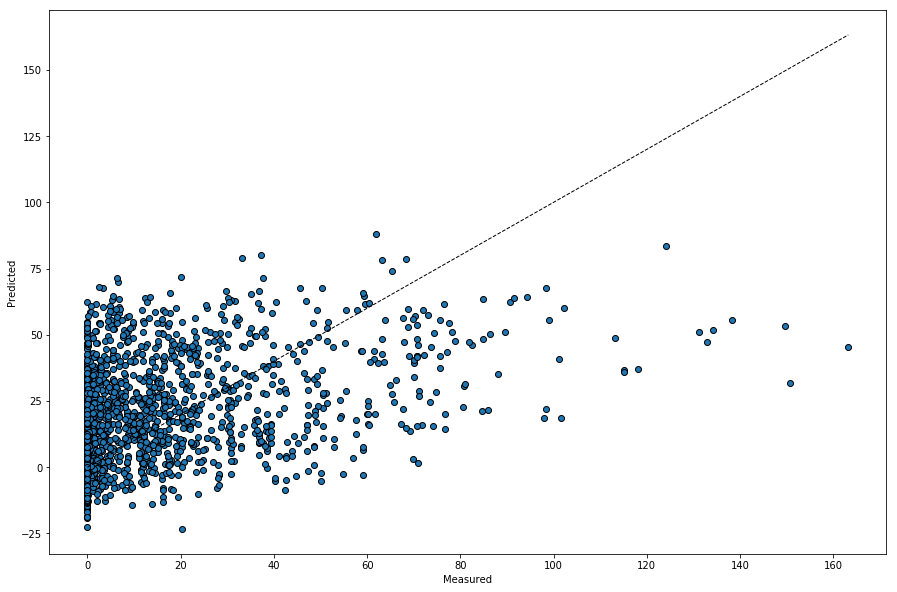

In [150]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()